### Student Information
Name: 胡紹良

Student ID: 110006202

GitHub ID:

Kaggle name: 

Kaggle private scoreboard snapshot:

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

## 1. Data Preparation

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## 1.1 Load Json data

We start by loading the json file into a single pandas dataframe and normalize it.

In [19]:
### Begin Assignment Here
json_file = pd.read_json("tweets_DM.json", lines = True) # read the json file separated by lines
df = pd.json_normalize(json_file['_source']) # flatten the nested _source by normalizing it
df[['score','crawldate']] = json_file[['_score','_crawldate']] # copy score and crawldate from json file to df, we dont need index and type because every data has the same index and type
df[['tweet_id', 'text', 'hashtags']] = df[['tweet.tweet_id', 'tweet.text', 'tweet.hashtags']] # tidy up the features by removing the tweet prefix
df = df.drop(columns = ['tweet.hashtags', 'tweet.tweet_id', 'tweet.text'])
df

,score,crawldate,tweet_id,text,hashtags
0,391,2015-05-23 11:42:47,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat]
1,433,2016-01-28 04:52:09,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]"
2,232,2017-12-25 04:39:20,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse]
3,376,2016-01-24 23:53:05,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[]
4,989,2016-01-08 17:18:59,0x2de201,"""Trust is not the same as faith. A friend is s...",[]
...,...,...,...,...,...
1867530,827,2015-05-12 12:51:52,0x316b80,When you buy the last 2 tickets remaining for ...,"[mixedfeeling, butimTHATperson]"
1867531,368,2017-10-02 17:54:04,0x29d0cb,I swear all this hard work gone pay off one da...,[]
1867532,498,2016-10-10 11:04:32,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,[]
1867533,840,2016-09-02 14:25:06,0x24faed,"Ah, corporate life, where you can date <LH> us...",[]


## 1.2 load the csv files and join data_identification with df to know where to split

In [20]:
emotion_csv = pd.read_csv("emotion.csv") # load the emotion.csv for training
data_identification_csv = pd.read_csv("data_identification.csv") # load the data identification for data splitting
df = data_identification_csv.set_index('tweet_id').join(df.set_index('tweet_id')) #join the data_identification and df to know where to split


## 1.3 split the dataframe into training and testing dataframe

In [21]:
#split the df based on its identifications
train_df = df[df['identification']=='train']

test_df = df[df['identification']=='test']

In [22]:
train_df

,identification,score,crawldate,text,hashtags
tweet_id,,,,,
0x29e452,train,809,2015-01-17 03:07:03,Huge Respect🖒 @JohnnyVegasReal talking about l...,[]
0x2b3819,train,808,2016-07-02 09:34:06,Yoooo we hit all our monthly goals with the ne...,"[spateradio, app]"
0x2a2acc,train,16,2016-08-15 18:18:39,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,[]
0x2a8830,train,768,2017-02-11 08:49:46,Come join @ambushman27 on #PUBG while he striv...,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos..."
0x20b21d,train,70,2016-11-23 05:37:10,@fanshixieen2014 Blessings!My #strength little...,"[strength, bones, God]"
...,...,...,...,...,...
0x227e25,train,361,2016-09-09 14:28:19,@BBCBreaking Such an inspirational talented pe...,[rip]
0x293813,train,15,2017-02-04 14:15:32,And still #libtards won't get off the guy's ba...,"[libtards, Hillary, lost, sad, growup, Trump]"
0x1e1a7e,train,174,2015-12-03 16:53:39,When you sow #seeds of service or hospitality ...,"[seeds, Joy, GLTChurch]"


In [23]:
test_df

,identification,score,crawldate,text,hashtags
tweet_id,,,,,
0x28cc61,test,107,2017-01-17 14:13:32,@Habbo I've seen two separate colours of the e...,[]
0x2db41f,test,728,2015-10-17 06:46:20,@FoxNews @KellyannePolls No serious self respe...,[]
0x2466f6,test,491,2016-12-19 03:50:27,"Looking for a new car, and it says 1 lady owne...",[womendrivers]
0x23f9e9,test,28,2017-04-09 19:32:19,@cineworld “only the brave” just out and fount...,[robbingmembers]
0x1fb4e1,test,925,2016-01-15 11:59:31,Felt like total dog 💩 going into open gym and ...,[]
...,...,...,...,...,...
0x2c4dc2,test,792,2017-04-01 02:52:58,6 year old walks in astounded. Mum! Look how b...,[kids]
0x31be7c,test,34,2016-11-13 07:34:17,Only one week to go until the #inspiringvolunt...,[inspiringvolunteerawards2017]
0x1ca58e,test,976,2017-10-26 19:12:59,"I just got caught up with the manga for ""My He...",[]


In [24]:
# remove the identification feature from both testing and training to clean up the data
train_df = train_df.drop(columns = ['identification'])
test_df = test_df.drop(columns = ['identification'])

In [25]:
train_df

,score,crawldate,text,hashtags
tweet_id,,,,
0x29e452,809,2015-01-17 03:07:03,Huge Respect🖒 @JohnnyVegasReal talking about l...,[]
0x2b3819,808,2016-07-02 09:34:06,Yoooo we hit all our monthly goals with the ne...,"[spateradio, app]"
0x2a2acc,16,2016-08-15 18:18:39,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,[]
0x2a8830,768,2017-02-11 08:49:46,Come join @ambushman27 on #PUBG while he striv...,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos..."
0x20b21d,70,2016-11-23 05:37:10,@fanshixieen2014 Blessings!My #strength little...,"[strength, bones, God]"
...,...,...,...,...
0x227e25,361,2016-09-09 14:28:19,@BBCBreaking Such an inspirational talented pe...,[rip]
0x293813,15,2017-02-04 14:15:32,And still #libtards won't get off the guy's ba...,"[libtards, Hillary, lost, sad, growup, Trump]"
0x1e1a7e,174,2015-12-03 16:53:39,When you sow #seeds of service or hospitality ...,"[seeds, Joy, GLTChurch]"


In [26]:
test_df

,score,crawldate,text,hashtags
tweet_id,,,,
0x28cc61,107,2017-01-17 14:13:32,@Habbo I've seen two separate colours of the e...,[]
0x2db41f,728,2015-10-17 06:46:20,@FoxNews @KellyannePolls No serious self respe...,[]
0x2466f6,491,2016-12-19 03:50:27,"Looking for a new car, and it says 1 lady owne...",[womendrivers]
0x23f9e9,28,2017-04-09 19:32:19,@cineworld “only the brave” just out and fount...,[robbingmembers]
0x1fb4e1,925,2016-01-15 11:59:31,Felt like total dog 💩 going into open gym and ...,[]
...,...,...,...,...
0x2c4dc2,792,2017-04-01 02:52:58,6 year old walks in astounded. Mum! Look how b...,[kids]
0x31be7c,34,2016-11-13 07:34:17,Only one week to go until the #inspiringvolunt...,[inspiringvolunteerawards2017]
0x1ca58e,976,2017-10-26 19:12:59,"I just got caught up with the manga for ""My He...",[]


Giving emotion feature to train dataset

In [27]:
train_df = train_df.join(emotion_csv.set_index('tweet_id'))
train_df

,score,crawldate,text,hashtags,emotion
tweet_id,,,,,
0x29e452,809,2015-01-17 03:07:03,Huge Respect🖒 @JohnnyVegasReal talking about l...,[],joy
0x2b3819,808,2016-07-02 09:34:06,Yoooo we hit all our monthly goals with the ne...,"[spateradio, app]",joy
0x2a2acc,16,2016-08-15 18:18:39,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,[],trust
0x2a8830,768,2017-02-11 08:49:46,Come join @ambushman27 on #PUBG while he striv...,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos...",joy
0x20b21d,70,2016-11-23 05:37:10,@fanshixieen2014 Blessings!My #strength little...,"[strength, bones, God]",anticipation
...,...,...,...,...,...
0x227e25,361,2016-09-09 14:28:19,@BBCBreaking Such an inspirational talented pe...,[rip],disgust
0x293813,15,2017-02-04 14:15:32,And still #libtards won't get off the guy's ba...,"[libtards, Hillary, lost, sad, growup, Trump]",sadness
0x1e1a7e,174,2015-12-03 16:53:39,When you sow #seeds of service or hospitality ...,"[seeds, Joy, GLTChurch]",joy


save the train and test dataset to pickle file

In [28]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

## 2. Feature Engineering

## 2.1 check the data to gain insights

In [29]:
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

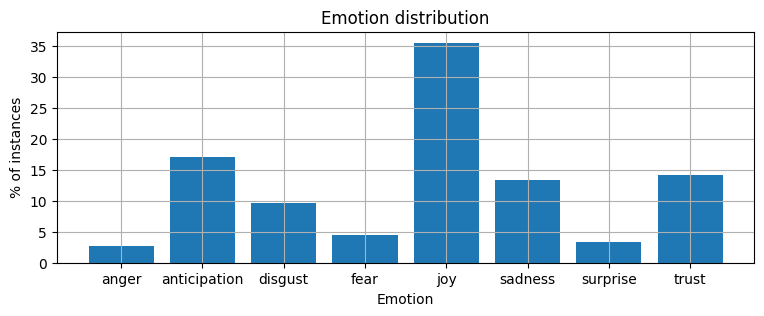

In [30]:
%matplotlib inline


# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(9,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

## 2.2 tf-IDF vectorizer for training and testing data

In [ ]:
TFIDF = TfidfVectorizer(tokenizer=nltk.word_tokenize) # use all the features

# Apply analyzer to all the datas
TFIDF.fit(df['text'])

# Transform documents to document-term matrix.
train_data_TFIDF = TFIDF.transform(train_df['text']) #for train_df
train_val = train_df['emotion']

test_data_TFIDF = TFIDF.transform(test_df['text']) #for test_df

c:\Users\Humam\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [32]:
train_data_TFIDF.shape

(1455563, 1169669)

In [33]:
train_data_TFIDF.shape

(1455563, 1169669)

Using one-hot encoding to transfrom train_val into numerical data

In [42]:
label_encoder = LabelEncoder()
label_encoder.fit(train_val)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', train_val[0:4])
print('\ny_train.shape: ', train_val.shape)
print('y_test.shape: ', train_val.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

train_val = label_encode(label_encoder, train_val)


print('\n\n## After convert')
print('y_train[0:4]:\n', train_val[0:4])
print('\ny_train.shape: ', train_val.shape)
print('y_test.shape: ', train_val.shape)


check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 tweet_id
0x29e452      joy
0x2b3819      joy
0x2a2acc    trust
0x2a8830      joy
Name: emotion, dtype: object

y_train.shape:  (1455563,)
y_test.shape:  (1455563,)


## After convert
y_train[0:4]:
 [[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]

y_train.shape:  (1455563, 8)
y_test.shape:  (1455563, 8)


Split train data into X_train and X_test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data_TFIDF, train_val, test_size=0.2, random_state=42)

In [44]:
## take a look at data dimension
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1164450, 1169669)
y_train.shape:  (1164450, 8)
X_test.shape:  (291113, 1169669)
y_test.shape:  (291113, 8)


## 3. Build Model

## 3.1 I/O check

In [45]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  1169669
output_shape:  8


Using Neural Network with layer like in the homework

In [48]:
# input layer
model_input = Input(shape=(input_shape, ))  # input shape
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1169669)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    74,858,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,863,560 (285.58 MB)

 Trainable params: 74,863,560 (285.58 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Train the model

In [ ]:
csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 5
batch_size = 512

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/5
   5/2275 ━━━━━━━━━━━━━━━━━━━━ 47:46 1s/step - accuracy: 0.6771 - loss: 0.9281

KeyboardInterrupt: 

## 3.3 Predict on testing data & check accuracy

In [ ]:
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

In [ ]:
plt.figure(figsize=(12, 5))
# figure for accuracies
plt.subplot(1,2,1)
plt.plot(training_log['accuracy'], label = 'Train accuracy')
plt.plot(training_log['val_accuracy'], label = 'Val accuracy')
plt.title('Training Accuracy per epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#figure for loss
plt.subplot(1,2,2)
plt.plot(training_log['loss'], label = 'Train loss')
plt.plot(training_log['val_loss'], label = 'Val loss')
plt.title('Training Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_true=y_test, y_pred=pred_result))